# Creating the model

In [1]:
%config InlineBackend.figure_format = 'retina'

Overwriting /home/gpetrini/Documentos/Pesquisas/SSM_Brochier/teste.py


In [2]:
import pandas as pd
from sympy import Abs

In [3]:
from pysolve3.model import Model
from pysolve3.utils import is_close,round_solution
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

def create_inet_model():
    model = Model()

    # Accounting
    model.set_var_default(0)
    model.var('Y', desc='GDP')
    model.var('C', desc='Consumption')
    model.var('Id', desc='Investment') # I is reserved to numpy
    model.var('Omega', desc='Wage share')
    model.var('Pi', desc='Profit share')
    
    # Identities
    model.var('K', desc='Capital Stock')
    model.var('gk', desc='Capital Stock growth rate')
    model.var('Yfc', desc='Full Capacity out-put')
    model.var('u', desc='Capacity utilization ration')
    
    # Households
    model.var('Yh', desc='Households’ income')
    model.var('Ydh', desc='Households’ disposable income')
    model.var('W', desc='Wages')
    model.var('FD', desc='Profits')
    model.var('Mh', desc='Bank deposits')
    model.var('B', desc='Government Bills')
    model.var('Sh', desc='Savings of Household')
    model.var('Vh', desc='Household net wealth')
    model.var('pe', desc='Equities price')
    model.var('Lambda', desc='proportion of household wealth allocated in equities')
    model.var('Eq', desc='Equities') # E is reserved for sympy

    # Firms
    model.var('Lf', desc='Firms Loans')
    model.var('FU', desc='Retained profits')
    model.var('Ft', desc='Total profits')
    model.var('Fg', desc='Gross Profits')
    model.var('h', desc='Propensity to invest')
    
    
    # Government
    model.var('G', desc='Government Expenditure')
    model.var('T', desc='Taxes')
    
    # Profits
    model.var('rn', desc='Net profit rate')
    model.var('rg', desc='Gross profit rate')
    
    # Accouting
    model.param('v', desc='Capital-Output ratio')
    model.param('mu', desc='Mark-up')
    
    #-----------------------------
    # Identities
    model.param('delta', desc='Depreciation')
    
    # Households
    model.param('Lambda0', desc='Expectation of return')
    model.param('alpha1', desc='Consumption Sensitivity of wages')
    model.param('alpha2', desc='Consumption Sensitivity of wealth')
    model.param('rm', desc= 'Deposits interest rate')
    model.param('rb', desc= 'Bills interest rate')
    model.param('tau', desc='Direct taxes')
    model.param('alpha4', desc='d(pe) effect')
    
    # Firms
    model.param('sf', desc='Distribution of profits')
    model.param('a', desc='Fixed parameter')
    model.param('gamma', desc='adjstment parameter')
    model.param('un', desc='Natural capacity utilization rate')
    
    
    # Government
    model.param('sigma', desc='Government expenditure rate')
    
    
    #-----------------------------
    model.add('B = B(-1) + G - T + rb*B(-1)') # Eq (1) # Checked
    model.add('G = sigma*Y(-1)') # Eq (2) # Checked
    model.add('T= tau*Yh') # Eq (3) # Checked
    model.add('Yh = W + FD + rm*(B(-1) + Mh(-1))') # Eq (4) # Checked
    model.add('W = (1-Pi)*Y') # Eq (5) # Checked
    model.add('Ydh = (1-tau)*Yh') # Eq (6) # Checked
    model.add('C = alpha1*(1-tau)*W + alpha2*Vh(-1)') # Eq (7) # Checked
    model.add('Sh = Ydh - C') # Eq (8) # Checked
    model.add('Lambda = Lambda0 - rb') # Eq (9) # Checked
    model.add('pe = (Lambda*Vh)/Eq') # Dynamic # Eq (10) # Checked
    model.add('Vh = Vh(-1) + Sh + d(pe)*Eq(-1)') # Eq (11) # Checked
    model.add('Mh = Mh(-1) + Sh - pe*d(Eq) - d(B)') # Eq (12) # Checked
    model.add('Pi = mu/(1+mu)') # Eq (13) # Checked
    model.add('Omega = 1 - Pi') # Aux (1) # Checked
    model.add('Id = h*Y') # Eq (14) # Checked
    model.add('h = h(-1) + if_true(u - un > 0.001)*h(-1)*gamma*(u-un) + if_true(un - u > 0.001)*h(-1)*gamma*(u-un)') # Eq (15)
    #model.add('h = h(-1) + h(-1)*gamma*(u-un)') # Aux (2)
    model.add('K = K(-1) + Id - delta*K(-1)') # Eq (16) # Corrected (delta*K(-1))
    model.add('Yfc = K(-1)/v') # Eq (17) # Checked
    model.add('u = Y/Yfc') # Eq (18) # Checked
    model.add('gk = (h*u)/v - delta') # Eq (19) # Checked
    model.add('Lf = Lf(-1) + Id - FU - pe*d(Eq)') # Eq (20) # Checked
    model.add('Eq = a*K(-1)') # Eq (21) # Checked
    model.add('FU = sf*(Pi*Y - rm*Lf(-1))') # Eq (22) # Checked
    model.add('FD= (1-sf)*(Pi*Y - rm*Lf(-1))') # Eq (23) # Checked
    model.add('Ft = (Pi*Y - rm*Lf(-1))') # Eq (24) # Checked
    model.add('Fg = Pi*Y') # Eq (25)
    model.add('rn = Pi*u/v - rb*(Lf(-1))/K(-2)') # Eq (26)
    model.add('rg = Pi*u/v') # Eq (26)

    model.add('Y = C + Id + G') # Eq (28)
    #----------------
    model.var('Z', desc='Autonomous')
    
    model.add('Z = alpha2*Vh(-1)')
    
    return model

# Defining values

In [4]:
parameters = {'h': 0.2,
              'gamma': 0.014,
              'delta': 0.044,
              'alpha1': 0.8,
              'alpha2': 0.03375,
              'sf': 0.4,
              'a':0.1,
              'sigma':0.34
             }

exogenous = {'mu': 0.7, #Pi = 0.411765
             'un': 0.8,
             'v': 2.5,
             'rm': 0.02,
             'rb': 0.02,
             'tau': 0.37,
             'Lambda0': 0.08,
             'pe': 0.9880216216216237
            }
initial = {'Eq': 9.80392156862745, # Warning
          'K' : 100,
           'Y' : 31.372549019607845,
          'B' : 73.65483130189038,
          'Vh' : 161.44144144144184,
          'Lf' : 78.29005476064303,
          'G' : 10.457516339869283,
          'Id' : 6.274509803921569,
          'C' : 14.640522875816991,
          'FD' : 6.829805584130843,
          'FU' : 4.553203722753896,
          'Sh' : 3.1655184596361137}

In [5]:
SFC_Base = create_inet_model()
SFC_Base.set_values(parameters)
SFC_Base.set_values(exogenous)
SFC_Base.set_values(initial)

# Solving

In [6]:
%time
start = 1700
time = 500


for i in range(start):
    SFC_Base.solve(iterations=100, threshold=1e-5)

for i in range(time):
    SFC_Base.solve(iterations=100, threshold=1e-5)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


# Getting data

In [7]:
Y = [s['Y'] for s in SFC_Base.solutions[start:]]
Ydh = [s['Ydh'] for s in SFC_Base.solutions[start:]]
Id = [s['Id'] for s in SFC_Base.solutions[start:]]
K = [s['K'] for s in SFC_Base.solutions[start:]]
C = [s['C'] for s in SFC_Base.solutions[start:]]
W = [s['W'] for s in SFC_Base.solutions[start:]]
u = [s['u'] for s in SFC_Base.solutions[start:]]
FD = [s['FD'] for s in SFC_Base.solutions[start:]]
FU = [s['FU'] for s in SFC_Base.solutions[start:]]
Ft = [s['Ft'] for s in SFC_Base.solutions[start:]]
Lf = [s['Lf'] for s in SFC_Base.solutions[start:]]
Mh = [s['Mh'] for s in SFC_Base.solutions[start:]]
Vh = [s['Vh'] for s in SFC_Base.solutions[start:]]
Eq = [s['Eq'] for s in SFC_Base.solutions[start:]]
pe = [s['pe'] for s in SFC_Base.solutions[start:]]
h = [s['h'] for s in SFC_Base.solutions[start:]]
G = [s['G'] for s in SFC_Base.solutions[start:]]
B = [s['B'] for s in SFC_Base.solutions[start:]]
Z = [s['Z']/s['Y'] for s in SFC_Base.solutions[start:]]
rn = [s['rn'] for s in SFC_Base.solutions[start:]]
rg = [s['rg'] for s in SFC_Base.solutions[start:]]

Lf_Y = [Lf[s]/Y[s] for s in range(2,time-start)]
Ft_Y = [Ft[s]/Y[s] for s in range(2,time-start)]
FU_Y = [FU[s]/Y[s] for s in range(2,time-start)]
FD_Y = [FD[s]/Y[s] for s in range(2,time-start)]

gY =  [(Y[i]-Y[i-1])/Y[i-1] for i in range(2,time-start)]
gId = [(Id[i]-Id[i-1])/Id[i-1] for i in range(2,time-start)]
gK = [(K[i]-K[i-1])/K[i-1] for i in range(2,time-start)]
gC = [(C[i]-C[i-1])/C[i-1] for i in range(2,time-start)]
gW = [(W[i]-W[i-1])/W[i-1] for i in range(2,time-start)]
gG = [(G[i]-G[i-1])/G[i-1] for i in range(2,time-start)]
gFD = [(FD[i]-FD[i-1])/FD[i-1] for i in range(2,time-start)]
gFU = [(FU[i]-FU[i-1])/FU[i-1] for i in range(2,time-start)]
gFt = [(Ft[i]-Ft[i-1])/Ft[i-1] for i in range(2,time-start)]
gLf = [(Lf[i]-Lf[i-1])/Lf[i-1] for i in range(2,time-start)]
gMh = [(Mh[i]-Mh[i-1])/Mh[i-1] for i in range(2,time-start)]
gVh = [(Vh[i]-Vh[i-1])/Vh[i-1] for i in range(2,time-start)]
gEq = [(Eq[i]-Eq[i-1])/Eq[i-1] for i in range(2,time-start)]
gB = [(B[i]-B[i-1])/B[i-1] for i in range(2,time-start)]
gZ = [(Z[i]-Z[i-1])/Z[i-1] for i in range(2,time-start)]


In [8]:
from pysolve3.utils import is_aclose, round_solution

def print_solutions(solns, vars, indexes):
    print("----------------")
    s = "{0:12} :".format('period')
    for i in indexes:
        s += "   {0: >10} ".format(i)
    print(s)
    for x in vars:
        s = "{0:12} :".format(x[0])
        for i in indexes:
            s += "   {0: >10.5f}".format(solns[i][x[1]])
            if i != 0:
                if not is_aclose([solns[i][x[1]],], [solns[i-1][x[1]],], rtol=1e-4):
                    s += '' #not closed yet
                else:
                    s += '*' #closed
            else:
                s += ' '
        print(s)

ax = sorted([(str(k), k) for k,v in SFC_Base.solutions[0].items()], key=lambda x: x[0])
print_solutions(SFC_Base.solutions, ax, [0, 1, 2, 3, -1])

nice_solution = round_solution(SFC_Base.solutions[-1], decimals=1)
#print_solutions([nice_solution,], ax, [0])

----------------
period       :            0             1             2             3            -1 
B            :     73.65483      75.70576     77.82754     80.01193   879139495277667680256.00000
C            :     14.64052      14.93711     15.18043     15.41565   45457336041602539520.00000
Eq           :      9.80392      10.00000     10.20009     10.40282   30486008305403645952.00000
FD           :      6.82981       6.96757      7.09028      7.20381   21213018163402825728.00000
FU           :      4.55320       4.64505      4.72686      4.80254   14142012108935217152.00000
Fg           :      0.00000      13.17842     13.41421     13.63529   40137494445322698752.00000
Ft           :      0.00000      11.61262     11.81714     12.00635   35355030272338042880.00000
G            :     10.45752      10.66667     10.88161     11.07631   32490390976258146304.00000
Id           :      6.27451       6.40095      6.51533      6.62232   19529107655445782528.00000
K            :    100.00

In [9]:
print('gk* = ', SFC_Base.evaluate('h*u/v - delta'))
print('v* = ', SFC_Base.evaluate('v'))
print('u* = ', SFC_Base.evaluate('u'))
print('h* = ', SFC_Base.evaluate('h'))
print('d(h)* = ', SFC_Base.evaluate('d(h)'))
print('delta* = ', SFC_Base.evaluate('delta'))

gk* =  0.020059247966498286
v* =  2.5
u* =  0.7993566363940583
h* =  0.20034626926809873
d(h)* =  0.0
delta* =  0.044


# Experiments

## Increase in real wages (decrease in $\mu$)

In [10]:
Shock1 = create_inet_model()
Shock1.set_values(parameters)
Shock1.set_values(exogenous)
Shock1.set_values(initial)

### Solving

In [11]:
%time
start = 1700
for i in range(start):
    Shock1.solve(iterations=100, threshold=1e-5)

Shock1.set_values({'mu': 0.63})

time = 500
for i in range(start + time):
    Shock1.solve(iterations=100, threshold=1e-5)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


In [12]:
dfSK1 = pd.DataFrame({"0":Shock1.solutions[start-1],
                     "Shock": Shock1.solutions[start],
                     "1": Shock1.solutions[start+1],
                     "2": Shock1.solutions[start+2],
                      "3": Shock1.solutions[start+3],
                      "t-1": Shock1.solutions[-2],
                     "t": Shock1.solutions[-1]})
dfSK1['difference'] = [(Shock1.solutions[-1][ax[i][1]] - Shock1.solutions[-2][ax[i][1]]) for i in range(len(Shock1.solutions[1]))]
dfSK1.style.format("{:.5g}")

,0,Shock,1,2,3,t-1,t,difference
B,4.2859e+16,4.3717e+16,4.4535e+16,4.5383e+16,4.6257e+16,2.8562e+38,2.9254e+38,6.9171e+36
C,2.1691e+15,2.2126e+15,2.3577e+15,2.4322e+15,2.5011e+15,1.5314e+38,1.5685e+38,3.7093e+36
Eq,1.4547e+15,1.4839e+15,1.5137e+15,1.5466e+15,1.5819e+15,1.0525e+38,1.078e+38,2.5494e+36
FD,1.0122e+15,1.0325e+15,1.0092e+15,1.0492e+15,1.0843e+15,6.5041e+37,6.6616e+37,1.5754e+36
FU,6.7482e+14,6.8836e+14,6.7277e+14,6.9948e+14,7.2287e+14,4.3361e+37,4.4411e+37,1.0503e+36
Fg,1.9153e+15,1.9537e+15,1.9194e+15,1.992e+15,2.0565e+15,1.3014e+38,1.333e+38,3.1524e+36
Ft,1.6871e+15,1.7209e+15,1.6819e+15,1.7487e+15,1.8072e+15,1.084e+38,1.1103e+38,2.6257e+36
G,1.5504e+15,1.5815e+15,1.6132e+15,1.6885e+15,1.7523e+15,1.1178e+38,1.1449e+38,2.7075e+36
Id,9.3188e+14,9.5057e+14,9.9521e+14,1.0333e+15,1.0674e+15,7.1805e+37,7.3544e+37,1.7393e+36
K,1.4839e+16,1.5137e+16,1.5466e+16,1.5819e+16,1.619e+16,1.078e+39,1.1041e+39,2.6112e+37


In [13]:
S1Y = [s['Y'] for s in Shock1.solutions[(start-50):]]
S1Id = [s['Id'] for s in Shock1.solutions[(start-50):]]
S1K = [s['K'] for s in Shock1.solutions[(start-50):]]
S1C = [s['C'] for s in Shock1.solutions[(start-50):]]
S1W = [s['W'] for s in Shock1.solutions[(start-50):]]
S1u = [s['u'] for s in Shock1.solutions[(start-50):]]
S1FD = [s['FD'] for s in Shock1.solutions[(start-50):]]
S1FU = [s['FU'] for s in Shock1.solutions[(start-50):]]
S1Ft = [s['Ft'] for s in Shock1.solutions[(start-50):]]
S1Lf = [s['Lf'] for s in Shock1.solutions[(start-50):]]
S1Mh = [s['Mh'] for s in Shock1.solutions[(start-50):]]
S1Vh = [s['Vh'] for s in Shock1.solutions[(start-50):]]
S1Eq = [s['Eq'] for s in Shock1.solutions[(start-50):]]
S1pe = [s['pe'] for s in Shock1.solutions[(start-50):]]
S1h = [s['h'] for s in Shock1.solutions[(start-50):]]
S1G = [s['G'] for s in Shock1.solutions[(start-50):]]
S1B = [s['B'] for s in Shock1.solutions[(start-50):]]
S1Z = [s['Z']/s['Y'] for s in Shock1.solutions[(start-50):]]
S1rn = [s['rn'] for s in Shock1.solutions[start-50:]]
S1rg = [s['rg'] for s in Shock1.solutions[start-50:]]
S1pe = [s['pe'] for s in Shock1.solutions[start-50:]]

S1Lf_Y = [S1Lf[s]/S1Y[s] for s in range(1,time+start)]
S1Ft_Y = [S1Ft[s]/S1Y[s] for s in range(1,time+start)]
S1FU_Y = [S1FU[s]/S1Y[s] for s in range(1,time+start)]
S1FD_Y = [S1FD[s]/S1Y[s] for s in range(1,time+start)]

S1gY =  [(S1Y[i]- S1Y[i-1])/S1Y[i-1] for i in range(1,time+start)]
S1gId = [(S1Id[i]-S1Id[i-1])/S1Id[i-1] for i in range(1,time+start)]
S1gK = [(S1K[i]-S1K[i-1])/S1K[i-1] for i in range(1,time+start)]
S1gC = [(S1C[i]-S1C[i-1])/S1C[i-1] for i in range(1,time+start)]
S1gW = [(S1W[i]-S1W[i-1])/S1W[i-1] for i in range(1,time+start)]
S1gG = [(S1G[i]-S1G[i-1])/S1G[i-1] for i in range(1,time+start)]
S1gFD = [(S1FD[i]-S1FD[i-1])/S1FD[i-1] for i in range(1,time+start)]
S1gFU = [(S1FU[i]-S1FU[i-1])/S1FU[i-1] for i in range(1,time+start)]
S1gFt = [(S1Ft[i]-S1Ft[i-1])/S1Ft[i-1] for i in range(1,time+start)]
S1gLf = [(S1Lf[i]-S1Lf[i-1])/S1Lf[i-1] for i in range(1,time+start)]
S1gMh = [(S1Mh[i]-S1Mh[i-1])/S1Mh[i-1] for i in range(1,time+start)]
S1gVh = [(S1Vh[i]-S1Vh[i-1])/S1Vh[i-1] for i in range(1,time+start)]
S1gEq = [(S1Eq[i]-S1Eq[i-1])/S1Eq[i-1] for i in range(1,time+start)]
S1gB = [(S1B[i]-S1B[i-1])/S1B[i-1] for i in range(1,time+start)]
S1gZ = [(S1Z[i]-S1Z[i-1])/S1Z[i-1] for i in range(1,time+start)]

## Figure 1 - Effects of an increase in real wages (reduction in μ ).

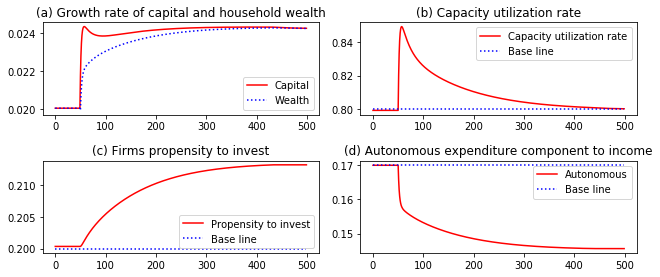

In [14]:
plot_limit = 500
bl_h = [0.2 for i in range(0, time + start)]
bl_u = [0.8 for i in range(0, time + start)]
bl_z = [0.17 for i in range(0, time + start)]

caption = 'Effects of an increase in real wages (reduction in μ)'
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)


plt.subplot(2, 2, 1)
plt.title('(a) Growth rate of capital and household wealth')
plt.tick_params(top=False, right=False)
plt.plot(S1gK[0:plot_limit], linestyle='-', color='r', label='Capital')
plt.plot(S1gVh[0:plot_limit], linestyle=':', color='b', label='Wealth')

plt.legend()


plt.subplot(2, 2, 2)
plt.title('(b) Capacity utilization rate')
plt.tick_params(top=False, right=False)
plt.plot(S1u[0:plot_limit], linestyle='-', color='r', label='Capacity utilization rate')
plt.plot(bl_u[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()


plt.subplot(2, 2, 3)
plt.title('(c) Firms propensity to invest')
plt.tick_params(top=False, right=False)
plt.plot(S1h[0:plot_limit], linestyle='-', color='r', label='Propensity to invest')
plt.plot(bl_h[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()

plt.subplot(2, 2, 4)
plt.title('(d) Autonomous expenditure component to income')
plt.tick_params(top=False, right=False)
plt.plot(S1Z[0:plot_limit], linestyle='-', color='r', label='Autonomous')
plt.plot(bl_z[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()

plt.subplots_adjust(right=1.5, hspace=0.5, wspace=0.15)
plt.show()

## Figure 2 - Effects of an increase in real wages (reduction in μ )

In [15]:
S1LfK = [S1Lf[i]/S1K[i-1] for i in range(1,time+start)]
S1BK = [S1B[i]/S1K[i-1] for i in range(1,time+start)] 
S1VhK = [S1Vh[i]/S1K[i-1] for i in range(1,time+start)]
S1T = [s['T'] for s in Shock1.solutions[start-50:]]
S1GT_Y = [(S1G[i] - S1T[i])/S1Y[i] for i in range(1,time+start)]
S1Basern = [S1rn[i]/rn[i] for i in range(time)]
S1Baserg = [S1rg[i]/rg[i] for i in range(time)]


bl_gt = [0 for i in range(0, time + start)]

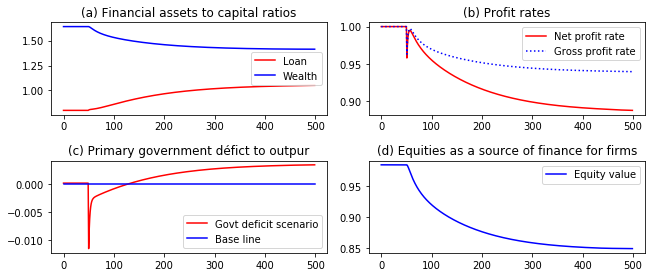

In [16]:
caption = 'Effects of an increase in real wages (reduction in μ)'
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)


plt.subplot(2, 2, 1)
plt.title('(a) Financial assets to capital ratios')
plt.tick_params(top=False, right=False)
plt.plot(S1LfK[0:plot_limit], linestyle='-', color='r', label='Loan')
plt.plot(S1VhK[0:plot_limit], linestyle='-', color='b', label='Wealth')
#plt.plot(S1BK[0:plot_limit], linestyle='-', color='g', label='Bills')

plt.legend()

plt.subplot(2, 2, 2)
plt.title('(b) Profit rates')
plt.tick_params(top=False, right=False)
plt.plot(S1Basern[0:plot_limit], linestyle='-', color='r', label='Net profit rate')
plt.plot(S1Baserg[0:plot_limit], linestyle=':', color='b', label='Gross profit rate')

plt.legend()

plt.subplot(2, 2, 3)
plt.title('(c) Primary government défict to outpur')
plt.tick_params(top=False, right=False)
plt.plot(S1GT_Y[0:plot_limit], linestyle='-', color='r', label='Govt deficit scenario')
plt.plot(bl_gt[0:plot_limit], linestyle='-', color='b', label='Base line')

plt.legend()

plt.subplot(2, 2, 4)
plt.title('(d) Equities as a source of finance for firms')
plt.plot(S1pe[0:plot_limit], linestyle='-', color='b', label='Equity value')

plt.legend()


plt.subplots_adjust(right=1.5, hspace=0.5, wspace=0.15)
plt.show()

## Increase in the propensity to consume out of after-tax wages ($\alpha_1$)

In [17]:
Shock2 = create_inet_model()
Shock2.set_values(parameters)
Shock2.set_values(exogenous)
Shock2.set_values(initial)

### Solving

In [18]:
%time
start = 1700
for i in range(start):
    Shock2.solve(iterations=100, threshold=1e-5)

Shock2.set_values({'alpha1': 0.84})

time = 500
for i in range(start + time):
    Shock2.solve(iterations=100, threshold=1e-5)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [19]:
dfSk2 = pd.DataFrame({"0":Shock2.solutions[start-1],
                     "Shock": Shock2.solutions[start],
                     "1": Shock2.solutions[start+1],
                     "2": Shock2.solutions[start+2],
                      "3": Shock2.solutions[start+3],
                      "t-1": Shock2.solutions[-2],
                     "t": Shock2.solutions[-1]})
dfSk2['difference'] = [(Shock2.solutions[-1][ax[i][1]] - Shock2.solutions[-2][ax[i][1]]) for i in range(len(Shock2.solutions[1]))]
dfSk2.style.format("{:.5g}")

,0,Shock,1,2,3,t-1,t,difference
B,4.2859e+16,4.3717e+16,4.4547e+16,4.5411e+16,4.6305e+16,3.3261e+37,3.4023e+37,7.6143e+35
C,2.1691e+15,2.2126e+15,2.3747e+15,2.4523e+15,2.5227e+15,9.7122e+36,9.9348e+36,2.2256e+35
Eq,1.4547e+15,1.4839e+15,1.5137e+15,1.547e+15,1.583e+15,6.6213e+36,6.773e+36,1.5173e+35
FD,1.0122e+15,1.0325e+15,1.0897e+15,1.1364e+15,1.1765e+15,4.5784e+36,4.6833e+36,1.0492e+35
FU,6.7482e+14,6.8836e+14,7.2647e+14,7.5763e+14,7.8435e+14,3.0523e+36,3.1222e+36,6.9946e+34
Fg,1.9153e+15,1.9537e+15,2.0536e+15,2.1364e+15,2.2082e+15,8.7229e+36,8.9228e+36,1.9989e+35
Ft,1.6871e+15,1.7209e+15,1.8162e+15,1.8941e+15,1.9609e+15,7.6307e+36,7.8056e+36,1.7486e+35
G,1.5504e+15,1.5815e+15,1.6132e+15,1.6957e+15,1.7641e+15,7.0413e+36,7.2026e+36,1.6136e+35
Id,9.3188e+14,9.5057e+14,9.9954e+14,1.0404e+15,1.0761e+15,4.4307e+36,4.5322e+36,1.0153e+35
K,1.4839e+16,1.5137e+16,1.547e+16,1.583e+16,1.6209e+16,6.773e+37,6.9282e+37,1.5521e+36


### Getting data

In [20]:
S2Y = [s['Y'] for s in Shock2.solutions[(start-50):]]
S2Id = [s['Id'] for s in Shock2.solutions[(start-50):]]
S2K = [s['K'] for s in Shock2.solutions[(start-50):]]
S2C = [s['C'] for s in Shock2.solutions[(start-50):]]
S2W = [s['W'] for s in Shock2.solutions[(start-50):]]
S2u = [s['u'] for s in Shock2.solutions[(start-50):]]
S2FD = [s['FD'] for s in Shock2.solutions[(start-50):]]
S2FU = [s['FU'] for s in Shock2.solutions[(start-50):]]
S2Ft = [s['Ft'] for s in Shock2.solutions[(start-50):]]
S2Lf = [s['Lf'] for s in Shock2.solutions[(start-50):]]
S2Mh = [s['Mh'] for s in Shock2.solutions[(start-50):]]
S2Vh = [s['Vh'] for s in Shock2.solutions[(start-50):]]
S2Eq = [s['Eq'] for s in Shock2.solutions[(start-50):]]
S2pe = [s['pe'] for s in Shock2.solutions[(start-50):]]
S2h = [s['h'] for s in Shock2.solutions[(start-50):]]
S2G = [s['G'] for s in Shock2.solutions[(start-50):]]
S2B = [s['B'] for s in Shock2.solutions[(start-50):]]
S2Z = [s['Z']/s['Y'] for s in Shock2.solutions[(start-50):]]
S2rn = [s['rn'] for s in Shock2.solutions[start-50:]]
S2rg = [s['rg'] for s in Shock2.solutions[start-50:]]

S2Lf_Y = [S2Lf[s]/S2Y[s] for s in range(1,time+start)]
S2Ft_Y = [S2Ft[s]/S2Y[s] for s in range(1,time+start)]
S2FU_Y = [S2FU[s]/S2Y[s] for s in range(1,time+start)]
S2FD_Y = [S2FD[s]/S2Y[s] for s in range(1,time+start)]

S2gY =  [(S2Y[i]- S2Y[i-1])/S2Y[i-1] for i in range(1,time+start)]
S2gId = [(S2Id[i]-S2Id[i-1])/S2Id[i-1] for i in range(1,time+start)]
S2gK = [(S2K[i]-S2K[i-1])/S2K[i-1] for i in range(1,time+start)]
S2gC = [(S2C[i]-S2C[i-1])/S2C[i-1] for i in range(1,time+start)]
S2gW = [(S2W[i]-S2W[i-1])/S2W[i-1] for i in range(1,time+start)]
S2gG = [(S2G[i]-S2G[i-1])/S2G[i-1] for i in range(1,time+start)]
S2gFD = [(S2FD[i]-S2FD[i-1])/S2FD[i-1] for i in range(1,time+start)]
S2gFU = [(S2FU[i]-S2FU[i-1])/S2FU[i-1] for i in range(1,time+start)]
S2gFt = [(S2Ft[i]-S2Ft[i-1])/S2Ft[i-1] for i in range(1,time+start)]
S2gLf = [(S2Lf[i]-S2Lf[i-1])/S2Lf[i-1] for i in range(1,time+start)]
S2gMh = [(S2Mh[i]-S2Mh[i-1])/S2Mh[i-1] for i in range(1,time+start)]
S2gVh = [(S2Vh[i]-S2Vh[i-1])/S2Vh[i-1] for i in range(1,time+start)]
S2gEq = [(S2Eq[i]-S2Eq[i-1])/S2Eq[i-1] for i in range(1,time+start)]
S2gB = [(S2B[i]-S2B[i-1])/S2B[i-1] for i in range(1,time+start)]
S2gZ = [(S2Z[i]-S2Z[i-1])/S2Z[i-1] for i in range(1,time+start)]

S2LfK = [S2Lf[i]/S2K[i-1] for i in range(1,time+start)]
S2BK = [S2B[i]/S2K[i-1] for i in range(1,time+start)] 
S2VhK = [S2Vh[i]/S2K[i-1] for i in range(1,time+start)]

## Figure 3 - Effects of an increase in the propensity to consume out of after-tax wages ($\alpha_1$)

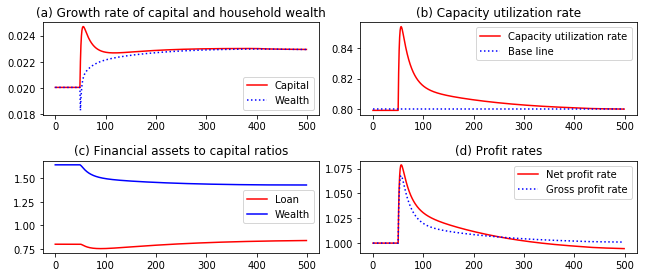

In [21]:
plot_limit = 500
S2Basern = [S2rn[i]/rn[i] for i in range(time)] # rn[1] = rn[start-50], so rn[50] is the first in SS 
S2Baserg = [S2rg[i]/rg[i] for i in range(time)]
bl_h = [0.2 for i in range(0, time + start)]
bl_u = [0.8 for i in range(0, time + start)]
bl_z = [0.17 for i in range(0, time + start)]

caption = 'Effects of an increase in real wages (reduction in μ)'
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)


plt.subplot(2, 2, 1)
plt.title('(a) Growth rate of capital and household wealth')
plt.tick_params(top=False, right=False)
plt.plot(S2gK[0:plot_limit], linestyle='-', color='r', label='Capital')
plt.plot(S2gVh[0:plot_limit], linestyle=':', color='b', label='Wealth')

plt.legend()

plt.subplot(2, 2, 2)
plt.title('(b) Capacity utilization rate')
plt.tick_params(top=False, right=False)
plt.plot(S2u[0:plot_limit], linestyle='-', color='r', label='Capacity utilization rate')
plt.plot(bl_u[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()


plt.subplot(2, 2, 3)
plt.title('(c) Financial assets to capital ratios')
plt.tick_params(top=False, right=False)
plt.plot(S2LfK[0:plot_limit], linestyle='-', color='r', label='Loan')
plt.plot(S2VhK[0:plot_limit], linestyle='-', color='b', label='Wealth')
#plt.plot(S2BK[0:plot_limit], linestyle='-', color='g', label='Bills')

plt.legend()

plt.subplot(2, 2, 4)
plt.title('(d) Profit rates')
plt.tick_params(top=False, right=False)
plt.plot(S2Basern[0:plot_limit], linestyle='-', color='r', label='Net profit rate')
plt.plot(S2Baserg[0:plot_limit], linestyle=':', color='b', label='Gross profit rate')

plt.legend()

plt.subplots_adjust(right=1.5, hspace=0.5, wspace=0.15)
plt.show()

## Figure 4 - Effects of an increase in the propensity to consume out of after-tax wages ( 𝛼1 )

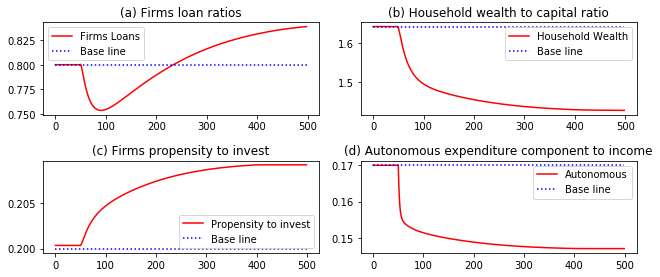

In [22]:
BaseLfK = [Lf[i]/K[i-1] for i in range(1,time)]
S2LfK = [S2Lf[i]/S2K[i-1] for i in range(1,time)]
BaseVhK = [Vh[i]/K[i-1] for i in range(1,time)]
S2VhK = [S2Vh[i]/S2K[i-1] for i in range(1,time)]

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

plt.subplot(2, 2, 1)
plt.title('(a) Firms loan ratios')
plt.tick_params(top=False, right=False)
plt.plot(S2LfK[0:plot_limit], linestyle='-', color='r', label='Firms Loans')
plt.plot(BaseLfK[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()

plt.subplot(2, 2, 2)
plt.title('(b) Household wealth to capital ratio')
plt.tick_params(top=False, right=False)
plt.plot(S2VhK[0:plot_limit], linestyle='-', color='r', label='Household Wealth')
plt.plot(BaseVhK[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()

plt.subplot(2, 2, 3)
plt.title('(c) Firms propensity to invest')
plt.tick_params(top=False, right=False)
plt.plot(S2h[0:plot_limit], linestyle='-', color='r', label='Propensity to invest')
plt.plot(bl_h[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()

plt.subplot(2, 2, 4)
plt.title('(d) Autonomous expenditure component to income')
plt.tick_params(top=False, right=False)
plt.plot(S2Z[0:plot_limit], linestyle='-', color='r', label='Autonomous')
plt.plot(bl_z[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()

plt.subplots_adjust(right=1.5, hspace=0.5, wspace=0.15)
plt.show()

##  Increase in the autonomous expenditure component ($\alpha_2$)

In [23]:
Shock3 = create_inet_model()
Shock3.set_values(parameters)
Shock3.set_values(exogenous)
Shock3.set_values(initial)

### Solving

In [24]:
start = 1700
for i in range(start):
    Shock3.solve(iterations=100, threshold=1e-5)

Shock3.set_values({'alpha2': 0.0374})

time = 500
for i in range(start + time):
    Shock3.solve(iterations=100, threshold=1e-5)

In [25]:
dfSk3 = pd.DataFrame({"0":Shock3.solutions[start-1],
                     "Shock": Shock3.solutions[start],
                     "1": Shock3.solutions[start+1],
                     "2": Shock3.solutions[start+2],
                      "3": Shock3.solutions[start+3],
                      "t-1": Shock3.solutions[-2],
                     "t": Shock3.solutions[-1]})
dfSk3['difference'] = [(Shock3.solutions[-1][ax[i][1]] - Shock3.solutions[-2][ax[i][1]]) for i in range(len(Shock3.solutions[1]))]
dfSk3.style.format("{:.5g}")

,0,Shock,1,2,3,t-1,t,difference
B,4.2859e+16,4.3717e+16,4.4537e+16,4.5397e+16,4.6289e+16,6.4065e+37,6.5554e+37,1.4882e+36
C,2.1691e+15,2.2126e+15,2.3985e+15,2.4796e+15,2.5519e+15,1.9504e+37,1.9958e+37,4.5335e+35
Eq,1.4547e+15,1.4839e+15,1.5137e+15,1.5476e+15,1.5845e+15,1.3322e+37,1.3631e+37,3.0964e+35
FD,1.0122e+15,1.0325e+15,1.0971e+15,1.1481e+15,1.1906e+15,9.2077e+36,9.4217e+36,2.1402e+35
FU,6.7482e+14,6.8836e+14,7.314e+14,7.6537e+14,7.9371e+14,6.1385e+36,6.2812e+36,1.4268e+35
Fg,1.9153e+15,1.9537e+15,2.066e+15,2.1558e+15,2.2317e+15,1.7552e+37,1.796e+37,4.0797e+35
Ft,1.6871e+15,1.7209e+15,1.8285e+15,1.9134e+15,1.9843e+15,1.5346e+37,1.5703e+37,3.567e+35
G,1.5504e+15,1.5815e+15,1.6132e+15,1.7059e+15,1.7801e+15,1.4164e+37,1.4493e+37,3.2921e+35
Id,9.3188e+14,9.5057e+14,1.0056e+15,1.05e+15,1.0878e+15,8.9579e+36,9.1662e+36,2.0821e+35
K,1.4839e+16,1.5137e+16,1.5476e+16,1.5845e+16,1.6236e+16,1.3631e+38,1.3948e+38,3.1684e+36


In [26]:
S3Y = [s['Y'] for s in Shock3.solutions[(start-50):]]
S3Id = [s['Id'] for s in Shock3.solutions[(start-50):]]
S3K = [s['K'] for s in Shock3.solutions[(start-50):]]
S3C = [s['C'] for s in Shock3.solutions[(start-50):]]
S3W = [s['W'] for s in Shock3.solutions[(start-50):]]
S3u = [s['u'] for s in Shock3.solutions[(start-50):]]
S3FD = [s['FD'] for s in Shock3.solutions[(start-50):]]
S3FU = [s['FU'] for s in Shock3.solutions[(start-50):]]
S3Ft = [s['Ft'] for s in Shock3.solutions[(start-50):]]
S3Lf = [s['Lf'] for s in Shock3.solutions[(start-50):]]
S3Mh = [s['Mh'] for s in Shock3.solutions[(start-50):]]
S3Vh = [s['Vh'] for s in Shock3.solutions[(start-50):]]
S3Eq = [s['Eq'] for s in Shock3.solutions[(start-50):]]
S3pe = [s['pe'] for s in Shock3.solutions[(start-50):]]
S3h = [s['h'] for s in Shock3.solutions[(start-50):]]
S3G = [s['G'] for s in Shock3.solutions[(start-50):]]
S3B = [s['B'] for s in Shock3.solutions[(start-50):]]
S3Z = [s['Z']/s['Y'] for s in Shock3.solutions[(start-50):]]
S3rn = [s['rn'] for s in Shock3.solutions[start:]]
S3rg = [s['rg'] for s in Shock3.solutions[start:]]

S3Lf_Y = [S3Lf[s]/S3Y[s] for s in range(1,time+start)]
S3Ft_Y = [S3Ft[s]/S3Y[s] for s in range(1,time+start)]
S3FU_Y = [S3FU[s]/S3Y[s] for s in range(1,time+start)]
S3FD_Y = [S3FD[s]/S3Y[s] for s in range(1,time+start)]

S3gY =  [(S3Y[i]- S3Y[i-1])/S3Y[i-1] for i in range(1,time+start)]
S3gId = [(S3Id[i]-S3Id[i-1])/S3Id[i-1] for i in range(1,time+start)]
S3gK = [(S3K[i]-S3K[i-1])/S3K[i-1] for i in range(1,time+start)]
S3gC = [(S3C[i]-S3C[i-1])/S3C[i-1] for i in range(1,time+start)]
S3gW = [(S3W[i]-S3W[i-1])/S3W[i-1] for i in range(1,time+start)]
S3gG = [(S3G[i]-S3G[i-1])/S3G[i-1] for i in range(1,time+start)]
S3gFD = [(S3FD[i]-S3FD[i-1])/S3FD[i-1] for i in range(1,time+start)]
S3gFU = [(S3FU[i]-S3FU[i-1])/S3FU[i-1] for i in range(1,time+start)]
S3gFt = [(S3Ft[i]-S3Ft[i-1])/S3Ft[i-1] for i in range(1,time+start)]
S3gLf = [(S3Lf[i]-S3Lf[i-1])/S3Lf[i-1] for i in range(1,time+start)]
S3gMh = [(S3Mh[i]-S3Mh[i-1])/S3Mh[i-1] for i in range(1,time+start)]
S3gVh = [(S3Vh[i]-S3Vh[i-1])/S3Vh[i-1] for i in range(1,time+start)]
S3gEq = [(S3Eq[i]-S3Eq[i-1])/S3Eq[i-1] for i in range(1,time+start)]
S3gB = [(S3B[i]-S3B[i-1])/S3B[i-1] for i in range(1,time+start)]
S3gZ = [(S3Z[i]-S3Z[i-1])/S3Z[i-1] for i in range(1,time+start)]

## Figure 5 - Effects of an increase in the autonomous expenditure component ($\alpha_2$)

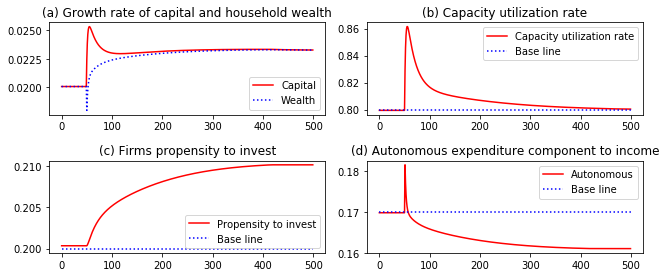

In [27]:
plot_limit = 500
bl_h = [0.2 for i in range(0, time + start)]
bl_u = [0.8 for i in range(0, time + start)]
bl_z = [0.17 for i in range(0, time + start)]

caption = 'Effects of an increase in real wages (reduction in μ)'
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)


plt.subplot(2, 2, 1)
plt.title('(a) Growth rate of capital and household wealth')
plt.tick_params(top=False, right=False)
plt.plot(S3gK[0:plot_limit], linestyle='-', color='r', label='Capital')
plt.plot(S3gVh[0:plot_limit], linestyle=':', color='b', label='Wealth')

plt.legend()


plt.subplot(2, 2, 2)
plt.title('(b) Capacity utilization rate')
plt.tick_params(top=False, right=False)
plt.plot(S3u[0:plot_limit], linestyle='-', color='r', label='Capacity utilization rate')
plt.plot(bl_u[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()


plt.subplot(2, 2, 3)
plt.title('(c) Firms propensity to invest')
plt.tick_params(top=False, right=False)
plt.plot(S3h[0:plot_limit], linestyle='-', color='r', label='Propensity to invest')
plt.plot(bl_h[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()

plt.subplot(2, 2, 4)
plt.title('(d) Autonomous expenditure component to income')
plt.tick_params(top=False, right=False)
plt.plot(S3Z[0:plot_limit], linestyle='-', color='r', label='Autonomous')
plt.plot(bl_z[0:plot_limit], linestyle=':', color='b', label='Base line')

plt.legend()

plt.subplots_adjust(right=1.5, hspace=0.5, wspace=0.15)
plt.show()

# Comparing

In [28]:
dfcomp = pd.DataFrame({"Base Scenario":SFC_Base.solutions[-1],
                     "Scenario 1": Shock1.solutions[-1],
                     "Scenario 3": Shock2.solutions[-1],
                     "Scenario 2": Shock3.solutions[-1],
                     })
dfcomp.loc['a':,].style.format("{:.5g}")

,Base Scenario,Scenario 1,Scenario 3,Scenario 2
a,0.1,0.1,0.1,0.1
alpha1,0.8,0.8,0.84,0.8
alpha2,0.03375,0.03375,0.03375,0.0374
delta,0.044,0.044,0.044,0.044
gamma,0.014,0.014,0.014,0.014
gk,0.020059,0.024222,0.022916,0.023244
h,0.20035,0.21325,0.20915,0.21015
mu,0.7,0.63,0.7,0.7
pe,0.98496,0.84811,0.85627,0.8462
rb,0.02,0.02,0.02,0.02


# Analytical solution and Steady-State inital stocks values

In [29]:
from sympy.interactive import printing
from sympy import Symbol, symbols, Function, simplify, solve
import sympy as sp
printing.init_printing(use_latex = True)

t = Symbol('t') # time

Defining  function objects

In [30]:
Y = Function('Y')
C = Function('C')
Id = Function('Id')
Omega = Function('Omega')
pi = Function('pi')
K = Function('K')
gK = Function('gK')
Yfc = Function('Yfc')
u = Function('u')
Yh = Function('Yh')
Yd = Function('Yd')
W = Function('W')
FD = Function('FD')
Mh = Function('Mh')
B = Function('B')
Sh = Function('Sh')
Vh = Function('Vh')
pe = Function('pe')
Lambda = Function('lambda') # lambda is reserved to python basic
Eq = Function('Eq') # E is reserved for numpy
Lf = Function('Lf')
FU = Function('FU')
Ft = Function('Ft')
Fg = Function('Fg')
h = Function('h')
G = Function('G')
T = Function('T')

In [31]:
delta = Symbol('delta')
Lambda0 = Symbol('lambda0')
mu = Symbol('mu')
alpha1 = Symbol('alpha1')
alpha2 = Symbol('alpha2')
r = Symbol('r') # rm = rb
tau = Symbol('tau')
sf = Symbol('s_f')
a = Symbol('a')
gamma = Symbol('gamma')
un = Symbol('u_n')
sigma = Symbol('sigma')
v = Symbol('v')

In [32]:
vh_eq = Symbol('vh^*')
b_eq = Symbol('b^*')
l_eq = Symbol('l^*')
h_eq = Symbol('h^*')
pi_fixed = Symbol('pi')
g_eq = Symbol('g^*')

Lambda = Symbol('lambda')
irb = Symbol('i_r')

## Shot-run Equilibrium

In [33]:
Eq1 = B(t-1) + G(t) - T(t) + r*B(t-1) # B(t)
Eq2 = sigma*Y(t-1) # G(t)
Eq3 = tau*Yh(t) # T(t)
Eq4 = W(t) + FD(t) + r*(B(t-1) + Mh(t-1))  # Yh(t)
Eq5 = (1-pi(t))*Y(t) # W(t)
Eq6 = (1-tau)*Yh(t) # Yd
Eq7 = alpha1*(1-tau)*W(t) + alpha2*Vh(t-1) # C(t)
Eq8 = Yd(t) - C(t) # Sh(t)
Eq9 = Lambda0(t) - r # Lambda(t)
Eq10 = (Lambda(t)*Vh(t))/Eq(t) # pe(t)
Eq11 = Vh(t-1) + Sh(t) + (pe(t) - pe(t-1))*Eq(t-1) #Vh(t)
Eq12 = Mh(t-1) + Sh(t) - pe(t)*(Eq(t) - Eq(t-1)) - (B(t) - B(t-1)) # Mh
Eq13 = mu/(1+mu) # Pi
Eq14 = h(t)*Y(t) # Id
Eq15 = h(t-1) + h(t-1)*gamma(t)*(u(t) - un) #h(t)
Eq16 = K(t-1) + Id(t) - delta*K(t-1) # K(t)
Eq17 = K(t-1)/v # Yfc
Eq18 = Y(t)/Yfc(t) #u
Eq19 = (h(t)*u(t))/v - delta # gK
Eq20 = Lf(t-1) + Id(t) - FU(t) - pe(t)*(Eq(t) - Eq(t-1)) # Lf
Eq21 = a*K(t-1) # Eq
Eq22 = sf*(pi(t)*Y(t) - r*Lf(t-1)) #FU
Eq23 = (1-sf)*(pi(t)*Y(t) - r*Lf(t-1)) #FD
Eq24 = (pi(t)*Y(t) - r*Lf(t-1)) #Ft
Eq25 = pi(t)*Y(t) #Fg
Eq28 = C(t) + Id(t) + G(t) # GDP (Y(t))

In [34]:
Eq29a = Eq28.subs(C(t), Eq7) - Y(t) #IMPORTANT: To solve the system
Eq29a

In [35]:
Eq29b = Eq29a.subs(Id(t), Eq14)
Eq29b

In [36]:
Eq29c = Eq29b.subs(G(t), Eq2)
Eq29c

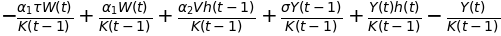

In [37]:
Eq29k = (Eq29c/K(t-1)).expand() # Y -> u/v
Eq29k

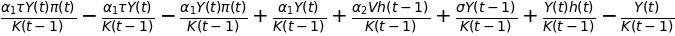

In [38]:
Eq29w = Eq29k.subs(W(t), Eq5).expand()
Eq29w

Rearranging:

$$Y_{t-1} = \frac{Y_t}{(1+g_{Y_{t-1}})}$$

And

$$K_{t-1} = \frac{K_t}{(1+g_{K_{t-1}})}$$

Then

$$\frac{Y_{t-1}}{K_{t-1}} = \frac{1}{v}\frac{(1+g_{K_{t-1}})}{(1+g_{Y_{t-1}})}$$

So

$$\frac{ Y_{t-1}}{K_{t-1}} = \frac{Y_t}{K_{t-1}}\frac{1}{(1+g_{Y_{t-1}})} = \frac{u_t}{v}\frac{1}{(1+g_{Y_{t-1}})}$$

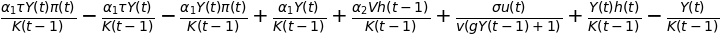

In [39]:
gY = Function('gY')
Eq29t = Eq29w.subs(Y(t-1)/K(t-1), (u(t)/v)*(1/(1+gY(t-1))))
Eq29t

Rearranging:

$$\frac{Y_t}{K_{t-1}} = \frac{u_t}{v}$$


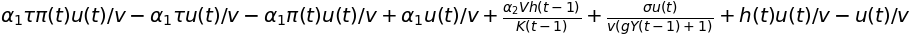

In [40]:
Eq29u = Eq29t.subs((Y(t)/K(t-1)), u(t)/v)
Eq29u

From footnote 22:

$$\frac{Vh_{t-1}}{K_{t-1}} = \frac{vh_{t-1}}{(1+gK_{t-1})}$$

where

$$vh_{t-1} = \frac{Vh_{t-1}}{K_{t-2}}$$

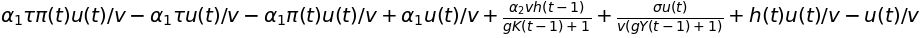

In [41]:
vh = Function('vh')
Eq29vh = Eq29u.subs((Vh(t-1)/K(t-1)), vh(t-1)/(1+gK(t-1)))
Eq29vh

Solving for $u_t$

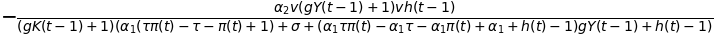

In [42]:
EqSR = (Eq29vh)
EqSR
solve(EqSR, u(t))[0].factor().collect(gY(t-1)).collect(alpha1).collect(sigma)

Rearranging:
$$
u_t = -\frac{(1+g_{Y_{t-1}})(\alpha_2v_{h_{t-1}}v)}{(1+ g_{K_{t-1}})(1+g_{Y_{t-1}})(\alpha_1(1-\tau)(1-\pi) + h_t -1) + \sigma}
$$

$$
u_t = -\frac{(\alpha_2v_{h_{t-1}}v)}{(1+ g_{K_{t-1}})(-1 + \alpha_1(1-\tau)(1-\pi) + h_t) + \frac{\sigma}{(1+g_{Y_{t-1}})}}
$$

$$
u_t = \frac{\alpha_2v_{h_{t-1}}v}{(1+ g_{K_{t-1}})(1 - \alpha_1(1-\tau)(1-\pi) - h_t) - \frac{\sigma}{(1+g_{Y_{t-1}})}}
$$

## Long-run Equilibrium

Making $gK_{t-1} = gK_t = gK^*$

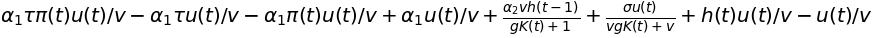

In [43]:
Eq29gk = Eq29vh.subs(gK(t-1), gK(t)).subs(gY(t-1), gK(t)).expand()
Eq29gk

Making $h_t = h_{t-1}$ which means $\Delta h = 0$ then $u_t = u_n$

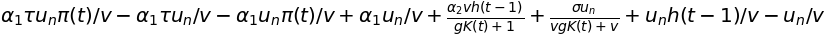

In [44]:
Eq29un = Eq29gk.subs(h(t), h(t-1)).subs(h(t-1), Eq15).subs(u(t),un).expand()
Eq29un

Solving for $g_K$ ($\equiv gY$ in the long run) 

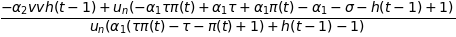

In [45]:
EqLR = Eq29un 
EqLR = solve(EqLR, gK(t))[0].simplify().collect(un).collect(alpha1)
EqLR

Rearranging:
$$g^* = \frac{\alpha_2v_hv + \sigma u_n}{u_n(1 - \alpha_1(1-\tau)(1-\pi) - h_t)} - 1$$

Plugging values from appendix B

In [46]:
EqLR = EqLR.subs(vh(t-1), 1.646715)
EqLR = EqLR.subs(alpha2, 0.03375)
EqLR = EqLR.subs(un, 0.8)
EqLR = EqLR.subs(alpha1, 0.8)
EqLR = EqLR.subs(v, 2.5)
EqLR = EqLR.subs(tau, 0.37)
EqLR = EqLR.subs(h(t-1), 0.2)
EqLR = EqLR.subs(pi(t), 0.411765)
EqLR = EqLR.subs(sigma, 0.34)
EqLR
print('Rounding for 10 decimal places:\ng* = ', round(EqLR,10))
print('Rounding for 3 decimal places:\ng* = ', round(EqLR,3))

Rounding for 10 decimal places:
g* =  0.0201525659
Rounding for 3 decimal places:
g* =  0.02


## Initial stocks values

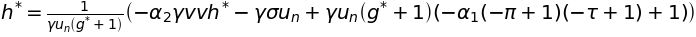

In [47]:
Eqb = sp.Eq(b_eq,(((sigma - tau*(1-sf*pi_fixed)*(1+g_eq)))*(un/v) - tau*irb*sf*l_eq)/(g_eq - irb*(1-tau)))
Eqb
Eql = sp.Eq(l_eq,((1+g_eq)*((h_eq - sf*pi_fixed)*un/v) - g_eq*Lambda*vh_eq)/(g_eq - sf*irb))
Eql
Eqvh = sp.Eq(vh_eq, ((1-tau)*(((1-alpha1 + pi_fixed*(alpha1-sf))*un/v*(1+g_eq)) + irb*b_eq + sf*irb*l_eq))/(g_eq + alpha2))
Eqvh
Eqh = sp.Eq(h_eq, ((1+g_eq)*gamma*un*(1-alpha1*(1-tau)*(1-pi_fixed)) - sigma*gamma*un - gamma*alpha2*vh_eq*v)/(gamma*un*(1+g_eq)))
Eqh

### Base scenario

In [48]:
growth = 0.02
#growth = EqLR
EqbBase = Eqb.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqbBase
EqlBase = Eql.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqlBase
EqvhBase = Eqvh.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqvhBase
EqhBase = Eqh.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqhBase
sp.solve([EqbBase, EqlBase,EqvhBase,EqhBase],
         [b_eq, l_eq, vh_eq, h_eq])

### Experiment 1 ($\pi = 0.411765 \Rightarrow 0.3865031$)

In [49]:
growth = 0.02421

EqbS1 = Eqb.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.3865031), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqbS1
EqlS1 = Eql.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.3865031), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqlS1
EqvhS1 = Eqvh.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.3865031), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqvhS1
EqhS1 = Eqh.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.3865031), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqhS1
sp.solve([EqbS1, EqlS1,EqvhS1,EqhS1],
         [b_eq, l_eq, vh_eq, h_eq])

### Experiment 2 ($\alpha_1 = 0.8 \Rightarrow 0.84$)

In [50]:
growth = 0.02291702

EqbS2 = Eqb.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.84),(gamma,0.014),
               (g_eq,growth)])
EqbS2
EqlS2 = Eql.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.84),(gamma,0.014),
               (g_eq,growth)])
EqlS2
EqvhS2 = Eqvh.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.84),(gamma,0.014),
               (g_eq,growth)])
EqvhS2
EqhS2 = Eqh.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.03375),(alpha1,0.84),(gamma,0.014),
               (g_eq,growth)])
EqhS2
sp.solve([EqbS2, EqlS2,EqvhS2,EqhS2],
         [b_eq, l_eq, vh_eq, h_eq])

### Experiment 3 ($\alpha_2 = 0.03375 \Rightarrow 0.0374$)

In [51]:
growth = 0.023161
#growth = EqLR
EqbS2 = Eqb.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.0374),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqbS2
EqlS2 = Eql.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.0374),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqlS2
EqvhS2 = Eqvh.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.0374),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqvhS2
EqhS2 = Eqh.subs([(sigma,0.34), (irb, 0.02),(sf, 0.4),(tau, 0.37),(un,0.8),(pi_fixed,0.411765), (v,2.5),(Lambda,(0.08-0.02)),(alpha2,0.0374),(alpha1,0.8),(gamma,0.014),
               (g_eq,growth)])
EqhS2
sp.solve([EqbS2, EqlS2,EqvhS2,EqhS2],
         [b_eq, l_eq, vh_eq, h_eq])

In [52]:
ax = sorted([(str(k), k) for k,v in SFC_Base.solutions[0].items()], key=lambda x: x[0])
symb = [a for (a,b) in ax]
variables = [print(a) for (a,b) in ax]
Symbols = [Symbol(symb[i]) for i in range(len(symb))]

B
C
Eq
FD
FU
Fg
Ft
G
Id
K
Lambda
Lambda0
Lf
Mh
Omega
Pi
Sh
T
Vh
W
Y
Ydh
Yfc
Yh
Z
_B__1
_Eq__1
_K__1
_K__2
_Lf__1
_Mh__1
_Vh__1
_Y__1
_h__1
_pe__1
a
alpha1
alpha2
delta
gamma
gk
h
mu
pe
rb
rg
rm
rn
sf
sigma
tau
u
un
v


In [53]:
list(filter(lambda symb: "_" not in symb, ax))

[('B', 'B'),
 ('C', 'C'),
 ('Eq', 'Eq'),
 ('FD', 'FD'),
 ('FU', 'FU'),
 ('Fg', 'Fg'),
 ('Ft', 'Ft'),
 ('G', 'G'),
 ('Id', 'Id'),
 ('K', 'K'),
 ('Lambda', 'Lambda'),
 ('Lambda0', 'Lambda0'),
 ('Lf', 'Lf'),
 ('Mh', 'Mh'),
 ('Omega', 'Omega'),
 ('Pi', 'Pi'),
 ('Sh', 'Sh'),
 ('T', 'T'),
 ('Vh', 'Vh'),
 ('W', 'W'),
 ('Y', 'Y'),
 ('Ydh', 'Ydh'),
 ('Yfc', 'Yfc'),
 ('Yh', 'Yh'),
 ('Z', 'Z'),
 ('_B__1', '_B__1'),
 ('_Eq__1', '_Eq__1'),
 ('_K__1', '_K__1'),
 ('_K__2', '_K__2'),
 ('_Lf__1', '_Lf__1'),
 ('_Mh__1', '_Mh__1'),
 ('_Vh__1', '_Vh__1'),
 ('_Y__1', '_Y__1'),
 ('_h__1', '_h__1'),
 ('_pe__1', '_pe__1'),
 ('a', 'a'),
 ('alpha1', 'alpha1'),
 ('alpha2', 'alpha2'),
 ('delta', 'delta'),
 ('gamma', 'gamma'),
 ('gk', 'gk'),
 ('h', 'h'),
 ('mu', 'mu'),
 ('pe', 'pe'),
 ('rb', 'rb'),
 ('rg', 'rg'),
 ('rm', 'rm'),
 ('rn', 'rn'),
 ('sf', 'sf'),
 ('sigma', 'sigma'),
 ('tau', 'tau'),
 ('u', 'u'),
 ('un', 'un'),
 ('v', 'v')]